In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import tqdm

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d
from models import Similitude, JitterCI, JacobianCI

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#cmap = project_cmap()

In [4]:
dtype=torch.float32
models = []
ncells=100
#noise_scales = 10**np.arange(-4,0,dtype=np.float64)
#noise_scales = np.concatenate(([0],noise_scales,[0.5]))
noise_scales = np.linspace(0,0.5,3)
shifts = np.linspace(0, 0.708, 3) # rectification level
nn = len(noise_scales)
ns = len(shifts)
for i in range(nn):
    models.append([])
    for j in range(ns):
        #models[i].append(JitterCI(ncells=ncells,dtype=dtype,dropout=False,lr=1e-3,
        #                          p_magnitude=noise_scales[i],r_magnitude=1e-1,shift=shifts[j]))
        models[i].append(JacobianCI(ncells=100,dtype=dtype,lr=1e-3, shift=shifts[j], p_magnitude=noise_scales[i]))
        # set initial phases
        #models[i][-1].set_phases(torch.normal(torch.zeros((ncells,2))+0.2,0.01))

In [5]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(5000):
        #if epoch == 3500:
        #    model.p_magnitude=0
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    return loss_history, phases_history, metric_history, G_history

In [6]:
loss_histories, metric_histories, phases_histories, kdes, G_histories = [],[],[],[], []
step=50
res=64
for i in range(nn):
    loss_histories.append([])
    phases_histories.append([])
    kdes.append([])
    metric_histories.append([])
    G_histories.append([])
    for j in range(ns):
        loss_history, phases_history, metric_history, G_history = train_model(models[i][j])
        kde,_,_,_=models[i][j].phase_kde(res=res,bw_method=0.1)
        loss_histories[i].append(loss_history)
        metric_histories[i].append(metric_history)
        phases_histories[i].append([models[i][j].unit_cell.wrap(phases_history[::step][k]) 
                                    for k in range(len(phases_history[::step]))])
        kdes[i].append(kde)
        G_histories[i].append(G_history)
loss_histories = np.array(loss_histories)
phases_histories = np.array(phases_histories)
kdes = np.array(kdes)
metric_histories = np.array(metric_histories)
G_histories = np.array(G_histories)

100%|██████████| 5000/5000 [00:13<00:00, 381.32it/s]


ValueError: too many values to unpack (expected 3)

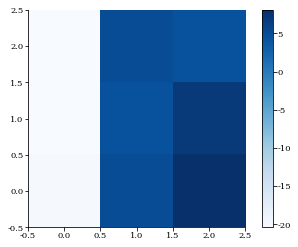

In [ ]:
plt.imshow(np.log(metric_histories[...,-1]),origin='lower')
#plt.imshow(metric_histories[...,-1],origin='lower')
plt.colorbar()

In [ ]:
# normalize kdes to [0,1]
zo_normalize = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))
kdes_norm = zo_normalize(kdes)

100%|██████████| 3/3 [00:00<00:00, 68.11it/s]


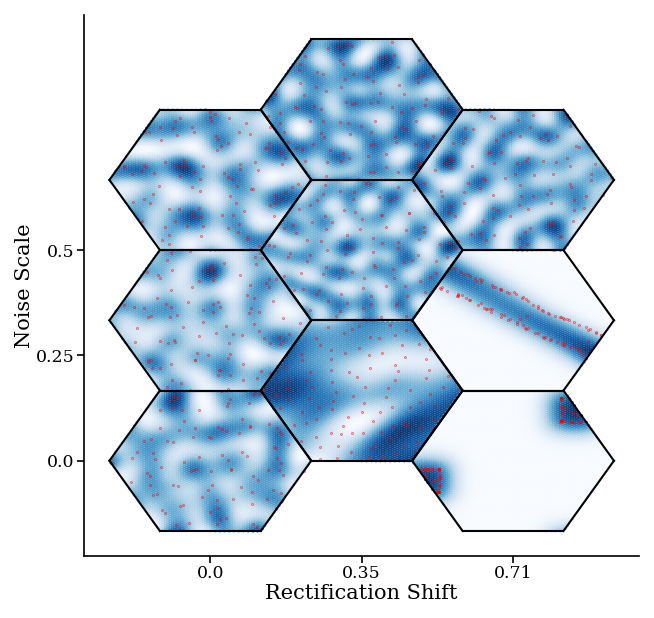

In [ ]:
import copy
figsize=set_size(fraction=1,mode='square')
fig,ax = plt.subplots(figsize=figsize,dpi=150)
#ax.axis('off')
#ax.axis('equal')
ax.set_xlabel('Rectification Shift')
ax.set_ylabel('Noise Scale')
center = np.zeros(2)
alphas = np.linspace(0.05,0.1,phases_histories.shape[2])
mesh = models[0][0].unit_cell.mesh(res)
for i in tqdm.trange(nn):
    center = -i*models[i][j].unit_cell.basis[-1]*2 # down
    for j in range(ns):
        # down-right + right
        center += (max((j-1),0)%2)*models[i][j].unit_cell.basis[0]*2 + (j%2)*models[i][j].unit_cell.basis[1]*2
        models[i][j].unit_cell.plot(ax=ax,center=center,color='black')#,alpha=np.log(metrics[i][j])/np.log(np.max(metrics)))
        model = copy.deepcopy(models[i][j])
        model.set_phases([[0,0]])
        activity=model(torch.tensor(mesh,dtype=dtype)).detach().numpy()[:,0]
        zero_mask = activity == 0
        contour_mask = (zero_mask.astype(int) + scipy.ndimage.binary_erosion(zero_mask.reshape(res,res),border_value=1).astype(int).reshape(-1)) == 1
        #ax.scatter(*(phases_histories[i,j]+center).T,c='grey',alpha=alphas,s=.5)
        ax.scatter(*(mesh+center).T,c=kdes_norm[i,j])#,alpha=0.2)
        ax.scatter(*(phases_histories[i,j,-1]+center).T,c='red',s=0.05)
        # plot contour of regions with zero activity
        #if i == 0:
        #    ax.scatter(*(mesh[contour_mask]+center).T,c='white',alpha=.4,s=.5)
    # plot square with center at center and size as noise scale
    # plot circle with center at center and radius as noise scale
    #left_center = -i*models[i][0].unit_cell.basis[-1]*2 # left column
    #ax.add_patch(plt.Circle(left_center,noise_scales[i]/2,fill=False,color='black',alpha=0.5))

ax.set_xticks(np.linspace(0,center[0],ns),labels=np.around(shifts,2))
ax.set_yticks(np.linspace(0,center[1]+models[0][0].unit_cell.basis[-1,1],nn),labels=np.around(noise_scales,2));

In [ ]:
fig.savefig(f'../results/relu-and-noise2-{model.__class__.__name__}.png')#,bbox_inches='tight')#,dpi=150)

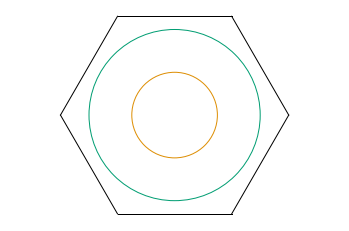

In [ ]:
fig, ax = model.unit_cell.plot(color='black')
ax.axis('off')
ax.axis('equal')
for i in range(len(noise_scales)):
    ax.add_patch(plt.Circle(np.zeros(2),noise_scales[i],fill=False,color=color_cycler[i]))
fig.savefig(f'../results/relu-and-noise-{model.__class__.__name__}-noise-scales.png')#,bbox_inches='tight')#,dpi=150)

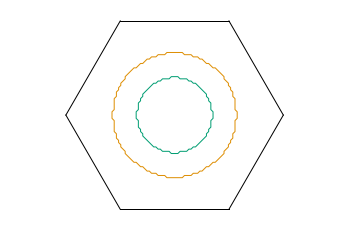

In [ ]:
r = model.unit_cell.radius
bins = np.linspace(-r,r,100)
xx, yy = np.meshgrid(bins, bins)
mesh = np.stack((xx.ravel(), yy.ravel()), axis = -1)
mask = ~model.unit_cell.is_in_hexagon(mesh)

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('equal')
model.unit_cell.plot(ax=ax,color='black')
for j in range(len(shifts)):
    centered_model = copy.deepcopy(models[0][j])
    centered_model.set_phases([[0,0]])
    activity = centered_model(torch.tensor(mesh,dtype=dtype)).detach().numpy()[:,0].reshape(100,100)
    activity[mask.reshape(100,100)] = np.nan
    ax.contour(xx, yy, activity, levels = [0] , colors=color_cycler[j])
    
#ax.imshow(activity, origin = 'lower', extent = (-r, r, -r, r))
fig.savefig(f'../results/relu-and-noise-{model.__class__.__name__}-contours.png')#,bbox_inches='tight')#,dpi=150)

In [ ]:
loss_histories.shape

(3, 3, 5000)

100%|██████████| 3/3 [00:00<00:00, 284.29it/s]


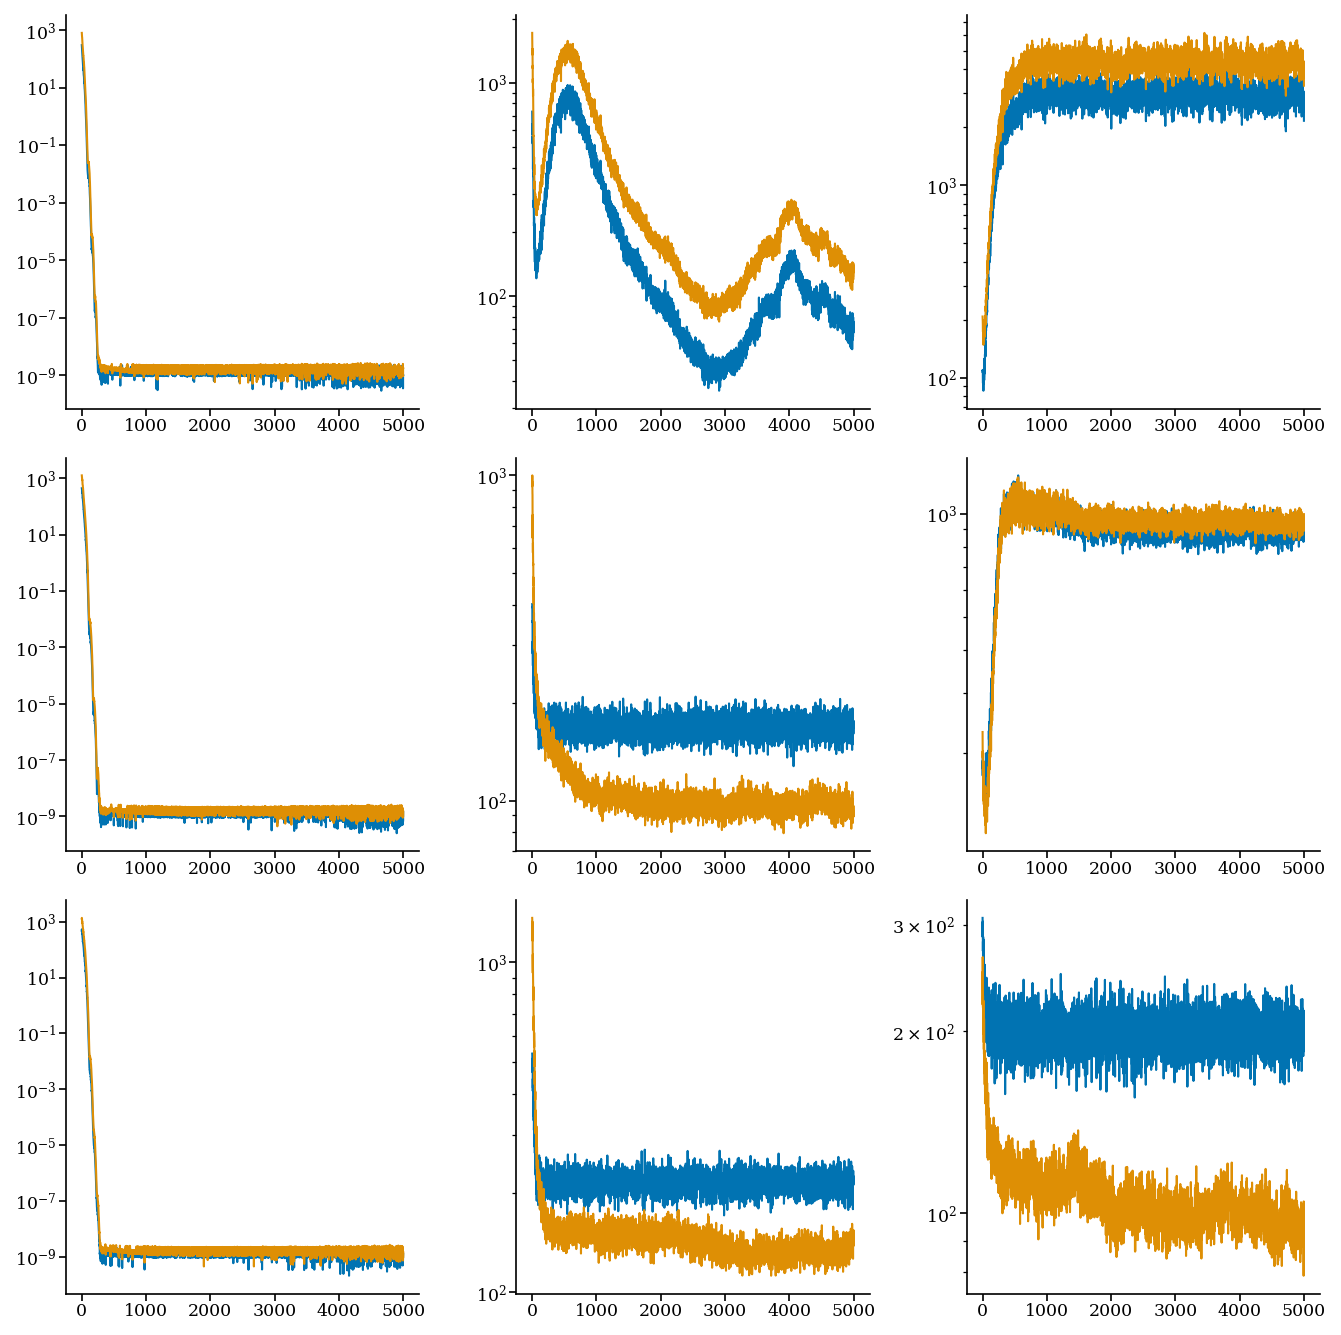

In [ ]:
fig,axs=plt.subplots(nrows=nn,ncols=ns,figsize=(ns*3,nn*3),dpi=150)
for i in tqdm.trange(nn):
    for j in range(ns):
        #axs[i,j].plot(loss_histories[i][j])
        axs[i,j].semilogy(loss_histories[i][j])
        axs[i,j].semilogy(metric_histories[i][j])
        #print(noise_scales[i], shifts[j], models[i][j].scale/100)
plt.tight_layout()

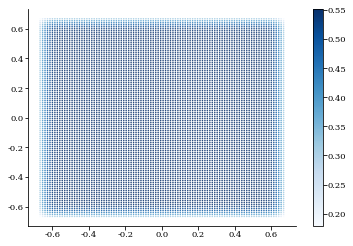

In [ ]:
kde_f = scipy.stats.gaussian_kde(mesh.T,bw_method=0.1)
plt.scatter(*mesh.T,c=kde_f(mesh.T))
plt.colorbar()